# CMIP Remapping

For training [Aurora](https://microsoft.github.io/aurora/intro.html) on ocean data

In [1]:
from collections import deque
from glob import glob
from pathlib import Path
import os
import re
import pyremap
import numpy as np
import xarray as xr
from datetime import datetime

***

## File discovery

I'm just focusing on the OMIP subset. Here I recursively navigate each simulate and grab one of the `tos` files to for building a map file.

In [2]:
# Datestamp and paths
datestamp = datetime.now().strftime('%Y%m%d')
scratch_root = '/path/to/scratch'
omip_root = '/path/to/OMIP'

Helper functions

In [3]:
def get_omip_filenames_recursively(
    path, depth=1, filenames=None, filetype='Omon', varname='tos', maxdepth=[5, 9],
):
    """Get OMIP filenames recursively. For building remapping files
    """

    # Initialize filenames
    if filenames is None:
        filenames = []

    # First maxdepth for hardcoding filetype and varname
    if depth == maxdepth[0]:
        path = path / filetype / varname
        if path.is_dir():
            depth = depth + 2
        else:
            return

    # Second maxdepth for getting the filename
    if depth == maxdepth[1]:
        files = sorted(f for f in path.iterdir() if f.is_file())
        if files:
            filenames.append(str(files[0]))

    # Normal recursion
    for sub in path.iterdir():
        if sub.is_dir():
            get_omip_filenames_recursively(sub, depth=depth+1, filenames=filenames)

    return filenames

Recursively get `tos` filenames

In [4]:
# Get a tos file from each omip entry
filenames = get_omip_filenames_recursively(Path(omip_root))

# Get model and grid info from each file
models = []
for filename in filenames:
    ds = xr.open_dataset(filename, decode_times=False)
    info = [string for string in re.split(r'[\n;]', ds.source) if 'ocean:' in string]
    if info:
        info = info[0].split('ocean:')[1].strip()
    else:
        info = '[empty]'
    models.append(f'{ds.source_id}, {ds.grid}, {info}')

# Get unique model/grid combos
models, idx = np.unique(models, return_index=True)
filenames = np.array(filenames)[idx]

/global/u1/b/bmoorema/miniforge3/envs/nersc-env/lib/python3.12/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Print unique model/grid combos from netCDF metadata

In [5]:
# Print unique model/grid combos
models

array(['ACCESS-OM2, tripolar ocean primarily 1 deg (360x300 lonxlat), ACCESS-OM2 (GFDL-MOM5, tripolar primarily 1deg',
       'ACCESS-OM2-025, tripolar ocean primarily 1/4 deg (1440x1080 lonxlat), ACCESS-OM2 (MOM5, tripolar primarily 1/4 deg',
       'CAS-ESM2-0, gs1x1, LICOM2.0 (LICOM2.0, primarily 1deg',
       'CESM2, native gx1v7 displaced pole grid (384x320 latxlon), POP2 (320x384 longitude/latitude',
       'CESM2, ocean data regridded from native gx1v7 displaced pole grid (384x320 latxlon) to 180x360 latxlon using conservative regridding, POP2 (320x384 longitude/latitude',
       'CMCC-CM2-HR4, standard, NEMO3.6 (ORCA0.25 1/4 deg from the Equator degrading at the poles',
       'CMCC-CM2-SR5, standard, NEMO3.6 (ORCA1 tripolar primarly 1 deg lat/lon with meridional refinement down to 1/3 degree in the tropics',
       'CMCC-ESM2, native ocean curvilinear grid, NEMO3.6 (ORCA1 tripolar primarly 1 deg lat/lon with meridional refinement down to 1/3 degree in the tropics',
       'CNR

Define shorthand configuration IDs for all unique model/grid combos.

In [6]:
# Custom grid names for each (potential duplicates marked)
modelnames = [
    'ACCESS-OM2-1deg',
    'ACCESS-OM2-025deg',
    'CAS-ESM2-0-gs1x1',
    'CESM2-gx1v7',
    'CESM2-180x360-conserve',
    'CMCC-CM2-HR4-ORCA025',
    'CMCC-CM2-SR5-ORCA1',
    'CMCC-ESM2-ORCA1',
    'CNRM-CM6-1-ORCA1',
    'CNRM-CM6-1-HR-ORCA025',
    'CNRM-ESM2-1-ORCA1',
    'CanESM5-ORCA1',
    'CanESM5-ORCA1', # duplicate
    'EC-Earth3-ORCA1',
    'FGOALS-f3-H-1440x720-conserve',
    'FGOALS-f3-L-1deg',
    'FIO-ESM-2-0-gx1v6',
    'GFDL-CM4-025deg',
    'GFDL-CM4-025deg', # duplicate
    'IPSL-CM6A-LR-ORCA13',
    'MIROC-ES2L-180x360-unspecified',
    'MIROC-ES2L-1deg',
    'MIROC6-1deg',
    'MRI-ESM2-0-180x360-aave',
    'MRI-ESM2-0-05deg',
    'NorESM2-LM-1deg',
    'TaiESM1-TIMCOM-1deg', # TIMCOMv1.7
    'TaiESM1-TIMCOM-1deg', # duplicate
    'TaiESM1-TIMCOM2-1deg', # TIMCOMv2.2
]

***

## Example: ACCESS-OM2

Here I'll show my remapping workflow for ACCESS-OM2. This should be similar for any curvilinear grid with 2D lon/lat fields.

In [ ]:
# Print path to ACCESS-OM2 `tos` file
filenames[0]

**(1) Build source SCRIP file (python)**

Here's what we need to do to build the ACCESS-OM2 SCRIP file (using [pyremap](https://github.com/MPAS-Dev/pyremap/tree/main)).

In [10]:
# Load nc
ds = xr.open_dataset(filenames[0], decode_times=False)

# Build mesh descriptor
descriptor = pyremap.LatLon2DGridDescriptor.read(
    ds=ds,
    latVarName='latitude',
    lonVarName='longitude',
)

# Save as SCRIP file
SCRIPname = os.path.join(scratch_root, f'ACCESS-OM2_scrip.{datestamp}.nc')
descriptor.to_scrip(SCRIPname)

**(2) Everything else (command line)**

   1. Generate target SCRIP (we can use this for all remapping)
```
ncremap -g cmip6_180x360_scrip.20250818.nc -G latlon=180,360
```

   2. Build weights file (couldn't get this to work for `-m conserve` but bet we could figure it out)
```
ESMF_RegridWeightGen -s ACCESS-OM2_scrip.20250818.nc -d cmip6_180x360_scrip.20250818.nc -w map_ACCESS-OM2_to_cmip6_180x360_bilinear.nc
```

   3. Trim problem variables (in this case `vertices_latitude` and `vertices_longitude` cause issues)

```
ncks -C -x -v vertices_latitude,vertices_longitude /path/to/tos_Omon_ACCESS-OM2.nc tempfile.nc
```

   4. Remapping (the `-R` args here apply lon and lat as coordinate variables)
```
ncremap -v tos -m map_ACCESS-OM2_to_cmip6_180x360_bilinear.nc -R '--rgr lat_dmn_nm=lat --rgr lon_dmn_nm=lon --rgr lat_nm_out=lat --rgr lon_nm_out=lon' tempfile.nc remapped.nc
```

**Preview remapped output**

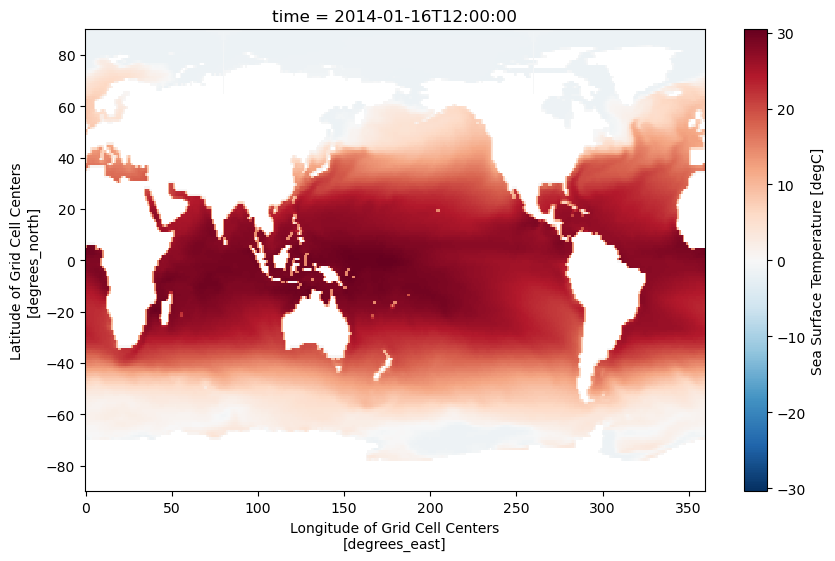

In [18]:
# Load remapped netCDF file and plot `tos` and time zero
ds = xr.open_dataset(f'{scratch_root}/remapped.nc')
ds.tos[0, ...].plot(figsize=(10, 6))